# **Puddle World**

In this guide, we provide a step-by-step walkthrough on preparing the Puddle World environment for the Competition.

Firstly, we cover the installation of the environment and related dependencies, both for local setup and utilization within a Colab notebook.

Next, we detail the process of initializing the environment with desired configurations and demonstrate how to visualize its characteristics. The goal of the competition is to design an agent that does well in the five provided configurations. Therefore, we show you how to load all the various versions of the environment and inspect their characteristics.

Given the objective of designing a competent agent, we present suggestions for deploying random, human, or untuned DQN agents within the environment. Observing all these different baseline behaviors serves as a valuable starting point for your work.

Finally, it's time to design and train a single agent capable of superior performance across the five configurations of the environment. Testing the agent on these configurations, with the first being the default environment as described in the paper, is crucial. We provide instructions on saving results in a CSV file for submission, marking the beginning of your journey.

Whether you're new to the field and eager to explore or an experienced practitioner aiming to refine your skills, this competition provides a platform to utilize your knowledge and creativity!

# 1. Installing the Requirements

In this section, you can find the necessary information for installing the environment and relavant libraries for your work.

## 1.1. For Google Colab

You can access the gym-puddle library for colab by installing the repository by the following command.
You can also include other necessary installations of your own here.

In [1]:
#!pip install git+https://github.com/Amii-Open-Source/gym-puddle.git
#!pip install git+https://github.com/DLR-RM/stable-baselines3@f375cc393938a6b4e4dc0fb1de82b4afca37c1bd
#!apt-get install -y xvfb x11-utils
#!pip install pyvirtualdisplay
#!pip install --upgrade ipykernel

## 1.2. Local

You can install the library locally by making a virtual environment, and installing the library by pip. The following commands show the details
You can also find the exact versions of other libraries in the `setup.py` file in the repository.


```
python -m venv myenv
source myenv/bin/activate
pip install -e .
```



# 2. Introduction to the Environment

The "Puddle World" environment provides an interface for reinforcement learning experiments. It features puddles and challenges agents to navigate to specified goal positions while avoiding the puddles with larger negative rewards.
You can access key details like starting position, goal location, and action noise levels. By printing these attributes, you can gain insights into the environment's layout and develop strategies for training reinforcement learning algorithms effectively within the Puddle World domain.
Here is the default Puddle World configuration inspired by the [original paper](/http://incompleteideas.net/papers/sutton-96.pdf):

**Actions**

There are four actions: up, down, right, and left.
Each action moves approximately 0.05 in these directions. For the case where an action would take the agent out of the screen limits, the action does not move the agent instead.

A random gaussian noise with standard deviation 0.01 is also added to the motion along both dimensions.

**Reward**

The reward is -1 for each time step, plus some additional penalty if the agent gets into the puddle.
The penalty is -400 times the distance into the puddle (distance to the nearest edge).


**Puddle Positions**

The puddles's top-left position is [0.  , 0.85] and [0.35, 0.9] respectively, and the width and height for them is [0.55, 0.2 ] and [0.2, 0.6].

**Start Position**

The agent starts each episode at [0.2, 0.4].

**Goal Position**

The episode ends succesfully if the agent reaches [1.0, 1.0] which is the goal position.


In [2]:

import gymnasium as gym
import gym_puddle

from stable_baselines3 import DQN, A2C,TD3,PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.td3 import MlpPolicy as TD3Policy
from stable_baselines3.a2c import MlpPolicy as A2CPolicy
from stable_baselines3.dqn import MlpPolicy as DQNPolicy
from stable_baselines3.ppo import MlpPolicy as PPOPolicy
from stable_baselines3.ppo import CnnPolicy as PPOCnnPolicy
from stable_baselines3.dqn import CnnPolicy as DQNCnnPolicy
from stable_baselines3.a2c import CnnPolicy as A2CCnnPolicy

import time
import json

import matplotlib.pyplot as plt
import numpy as np

from IPython import display
import pyvirtualdisplay
import cv2

Here are the printed details about the environment.

In [3]:
env = gym.make("PuddleWorld-v0")

print("start position:", env.get_wrapper_attr("start"))
print("goal position:", env.get_wrapper_attr("goal"))
print("goal threshold:", env.get_wrapper_attr("goal_threshold"))
print("action noise:", env.get_wrapper_attr("noise"))
print("agent's thrust:", env.get_wrapper_attr("thrust"))
print("puddle top left positions:", env.get_wrapper_attr("puddle_top_left"))
print("puddle widths and heights:", env.get_wrapper_attr("puddle_width"))
print("action space:", env.get_wrapper_attr("actions"))
print("observation space:", env.get_wrapper_attr("observation_space"))

start position: [0.2 0.4]
goal position: [1. 1.]
goal threshold: 0.1
action noise: 0.01
agent's thrust: 0.05
puddle top left positions: [array([0.  , 0.85]), array([0.35, 0.9 ])]
puddle widths and heights: [array([0.55, 0.2 ]), array([0.2, 0.6])]
action space: [array([-0.05,  0.  ]), array([0.05, 0.  ]), array([ 0.  , -0.05]), array([0.  , 0.05])]
observation space: Box(0, 255, (3, 156, 156), uint8)


Here is the visualization of the environment for the default configuration.

In [4]:
#some functions to help the visualization and interaction wit the environment

def visualize(frames, video_name = "video.mp4"):
    # Saves the frames as an mp4 video using cv2
    video_path = video_name
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(video_path, fourcc, 30, (width, height))
    for frame in frames:
        video_writer.write(frame)
    video_writer.release()

def online_rendering(image):
    #Visualize one frame of the image in a display
    ax.axis('off')
    img_with_frame = np.zeros((image.shape[0]+2, image.shape[1]+2, 3), dtype=np.uint8)
    img_with_frame[1:-1, 1:-1, :] = image
    ax.imshow(img_with_frame)
    display.display(plt.gcf())
    display.clear_output(wait=True)


def prepare_display():
    #Prepares display for onine rendering of the frames in the game
    _display = pyvirtualdisplay.Display(visible=False,size=(1400, 900))
    _ = _display.start()
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.axis('off')


def get_action():
    action = None
    while action not in ["w", "a", "s", "d", "W", "A", "S", "D"]:
        action = input("Enter action (w/a/s/d): ")
    if action == "w":
        return 3
    elif action == "a":
        return 0
    elif action == "s":
        return 2
    elif action == "d":
        return 1


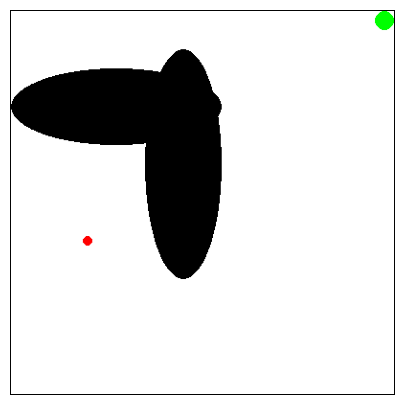

In [5]:
obs, info = env.reset()
image = env.render()
fig, ax = plt.subplots(figsize=(5, 5))
online_rendering(cv2.resize(image, (400,400)))

Note: In the subsequent sections of this document, we have used the `prepare_display()` function, which starts a virtual display to show the online rendering of the frames of the game. This function is needed if you want to run the code on Colab, since Colab does not natively support virtual displays.

However, if you are running your code on Windows, you don’t need this function. Instead, you can just rely on the `visualize()` function, which takes the list of frames as input and produces a video of the agent's performance in the game. Another way to visualize on Windows or Mac (or any system supporting virtual display windows) is to set the rendering mode to “human” at the beginning so that a window opens as the game starts and shows the online rendering.

Here is an snippet of how you can do this:

In [6]:
#env = gym.make("PuddleWorld-v0", render_mode="human") # you should set the render_mode to "human" to visualize the environment locally. If you are running this code snippet on colab, these lines won't work since colab doesn't support virtual display screens
#env.reset() #reset the environment to start a new episode
#env.render() #this will open a window to visualize the environment
#time.sleep(5) #wait for 5 seconds so that you can see the window
#env.close() #you should close the environment to close the virtual window at the end of your code

## 2.1 Accessing Different Environment Configurations

Your task is to train an agent that can generalize well across different provided configurations of the environment. Each of these configurations feature different positions for puddles, which makes it challenging for the agent to find the most rewarding path to the goal.


You can find these configurations in the `env_configs` folder of the repository. In order to access each version of the environment, you can provide the `.json` file indicating the environment details, and intitialize the puddle world as follows:
(Note that if you are using colab, you should upload the configs to the files section of the colab)
The puddle positions are different in these configurations, but other aspects of the environment remain the same.

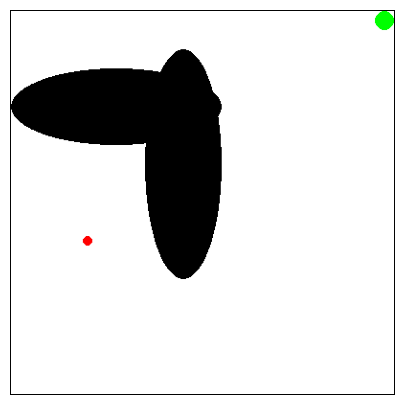

In [7]:
json_file = f"gym_puddle/env_configs/pw1.json"

with open(json_file) as f:
  env_setup = json.load(f)

env = gym.make(
  "PuddleWorld-v0",
  start=env_setup["start"],
  goal=env_setup["goal"],
  goal_threshold=env_setup["goal_threshold"],
  noise=env_setup["noise"],
  thrust=env_setup["thrust"],
  puddle_top_left=env_setup["puddle_top_left"],
  puddle_width=env_setup["puddle_width"],
)

obs, info = env.reset()
image = env.render()
fig, ax = plt.subplots(figsize=(5, 5))
online_rendering(np.transpose(image, (0, 1, 2)))

# 3. Developing the Agents

In preparation for the competition, we dive into the exploration of the RL framework through the introduction of three distinct agent types: random, human, and Deep Q-Network (DQN) agents.

Each agent represents varying levels of sophistication and learning abilities within the Puddle World environment. This comprehensive investigation allows us to gain valuable insights into key aspects of the environment as well as exploring RL-related methods such as the utilization of deep reinforcement learning strategies, and related libraries.

Through this exploration, you can familiarize yourself with the environment, grasp the details of the training loop, and become proficient in utilizing essential libraries such as Stable Baselines. This could be a starting point for building your own agent, either using existing libraries, and modifying them to your desires, or implementing new ideas from cutting-edge RL research!

## 3.3. DQN Agent

In this section, a  [ Deep Q-Network (DQN) agent](https://arxiv.org/abs/1312.5602) is utilized to interact with the Puddle World environment. The code demonstrates how to set up training with [Stable Baselines](https://stable-baselines3.readthedocs.io/en/master/), a popular library for reinforcement learning. The DQN model is initialized and trained using default hyperparameters, but you can explore and adjust these hyperparameters for optimal performance. After training, the trained model is loaded for evaluation. The environment is initialized, and the DQN agent's interaction with the environment is visualized. The agent selects actions based on the learned policy, and the environment responds accordingly. This process continues until the episode terminates. At the end of the episode, the total reward earned by the agent is displayed, and the sequence of frames captured during the interaction is saved as a video for further analysis. While the provided code serves as a starting point for training a DQN agent with stable baselines if you wish to use this library, you are encouraged to experiment with different hyperparameters to improve the agent's performance in navigating the complex dynamics of the Puddle World environment. We encourage you to explore more algorithms in the same library or build your agents from scratch.

In [8]:
import json
import os

# Define the path to the JSON file
file_path = 'gym_puddle/env_configs'

# Get a list of all files in the directory
all_files = os.listdir(file_path)

# Filter the list to include only JSON files
json_files = [file for file in all_files if file.endswith('.json')]

all_data = {}

# Loop through the JSON files, open each one, and load its content
for json_file in json_files:
    file_path_json = os.path.join(file_path, json_file)
    with open(file_path_json, 'r') as file:
        # Load the JSON content
        data = json.load(file)
        # Store the data using the filename as the key
        all_data[json_file] = data
all_data.keys()

dict_keys(['pw1.json', 'pw2.json', 'pw3.json', 'pw4.json', 'pw5.json', 'pw6.json'])

In [9]:
env_all = []
import random
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env

from stable_baselines3.common.monitor import Monitor

def make_env(env_id, config):
    def _init():
        env = Monitor(gym.make(env_id, **config))
        env.reset(seed = 0)
        return env
    return _init

for key, value in all_data.items():
        if key == "pw6.jspn":
             continue
        else:
            env = {"env_id" : "PuddleWorld-v0", 
                "config" : {"start":value["start"],
                "goal":value["goal"],
                "goal_threshold":value["goal_threshold"],
                "noise":value["noise"],
                "thrust":value["thrust"],
                "puddle_top_left":value["puddle_top_left"],
                "puddle_width":value["puddle_width"]
                }}
            env_all.append(env)
env_all_vec = DummyVecEnv([make_env(env["env_id"],env["config"]) for env in env_all])

In [10]:
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        if progress_remaining <=0.5 and progress_remaining > 0.25:
            return initial_value/10
        elif progress_remaining <=0.25:
            return initial_value/100
        elif progress_remaining <= 0.75 and progress_remaining> 0.5:
            return initial_value/2
        else:
            return initial_value
        
    return func

In [11]:

# Define the exponential learning rate schedule
def exp_schedule(initial_lr, decay_rate, decay_steps):
    """
    Exponential decay schedule function.

    :param initial_lr: (float) The initial learning rate
    :param decay_rate: (float) The decay rate
    :param decay_steps: (int) Number of steps for each decay
    :return: (function)
    """
    def schedule(progress):
        current_step = (1 - progress) * decay_steps
        return initial_lr * np.exp(-decay_rate * current_step)

    return schedule

In [12]:
import torch as th
import torch.nn as nn
from gymnasium import spaces

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: spaces.Box, features_dim: int = 256):
        super().__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:

        return self.linear(self.cnn(observations))

In [13]:
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.sb2_compat.rmsprop_tf_like import RMSpropTFLike

env_eval = Monitor(gym.make(env_all[1]["env_id"],**env_all[1]["config"]))
env_eval.reset(seed = 0)
#env = make_vec_env(env_all[2]["env_id"], env_kwargs=env_all[2]["config"],n_envs=4)


eval_callback = EvalCallback(env_eval, best_model_save_path="./logs/",
                             log_path="./logs/", eval_freq=10000,n_eval_episodes =2,
                             deterministic=True, render=False)

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=512),
    net_arch = [256, 256]
)


DQN_model = DQN(DQNCnnPolicy, env_all_vec, verbose=1, seed = 0, gamma = 0.9, optimize_memory_usage=True, 
                replay_buffer_kwargs={'handle_timeout_termination': False},
                policy_kwargs=policy_kwargs,batch_size=1024, train_freq=10, 
                gradient_steps=1,max_grad_norm=1.0, exploration_fraction=0.2, exploration_initial_eps=1.0, exploration_final_eps=0.005,
                learning_rate=0.00009, buffer_size=50000)

DQN_model = DQN_model.load('best_model_3.zip', env=env_all_vec,)

#PPO_model.learn(total_timesteps=2000000,callback=eval_callback)
#DQN_model.learn(total_timesteps=10000,callback=eval_callback)
#DQN_model.save("NEXT_BEST_2.zip")
# for j in range(len(env_all_vec.envs)):
#         env = make_vec_env(env_all[j]["env_id"], env_kwargs=env_all[j]["config"],n_envs=4)
#         env.reset()
#         PPO_model.set_env(env)
#         PPO_model.learn(total_timesteps=1000000)
#         env.close()

#DQN_model.save('new_best_model_final.zip')

Using cuda device


In [14]:
dqn_model = DQN_model
env_num = 2
env = gym.make(env_all[env_num]["env_id"],**env_all[env_num]["config"])

obs, info = env.reset(seed=1)

# Create an empty list to store the frames
frames = []
episode_rewards = []

for episode in range(1):
  total_reward = 0
  done = False
  num_steps = 0

  while not done and num_steps <=1000: # to avoid infinite loops for the untuned DQN we set a truncation limit, but you should make your agent sophisticated enough to avoid infinite-step episodes
      num_steps +=1
      action, _states = dqn_model.predict(obs)
      obs, reward, done, trunc, info = env.step(action)
      total_reward += reward
      if done == True:
        print("here")

      image = env.render()
      frames.append(image)

      if done:
        print(f"total reward in this episode: {total_reward}")
        episode_rewards.append(total_reward)
        total_reward = 0
        break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "DQN_" + str(env_num)+".mp4")


here
total reward in this episode: -26
episode 0: reward: -26


In [15]:

dqn_model = DQN_model
test_results = {'env_1': [], 'env_2': [], 'env_3': [], 'env_4': [], 'env_5': []}
for env_num in range(5):
  env = gym.make(env_all[env_num]["env_id"],**env_all[env_num]["config"])

  obs, info = env.reset()

  # Create an empty list to store the frames
  frames = []
  episode_rewards = []

  for episode in range(100):
    total_reward = 0
    done = False
    num_steps = 0

    while not done and num_steps <=1000: # to avoid infinite loops for the untuned DQN we set a truncation limit, but you should make your agent sophisticated enough to avoid infinite-step episodes
        num_steps +=1
        action, _states = dqn_model.predict(obs)
        obs, reward, done, trunc, info = env.step(action)
        total_reward += reward
        if done == True:
          print("here")

        image = env.render()
        frames.append(image)

        if done:
          print(f"total reward in this episode: {total_reward}")
          episode_rewards.append(total_reward)
          total_reward = 0
          break
    env.reset(seed = episode)
  env.close()

  if episode_rewards == []:
    print("no episode finished in this run.")
  else:
    for i, reward in enumerate(episode_rewards):
      print(f"episode {i}: reward: {reward}")

  visualize(frames, "DQN_" + str(env_num)+".mp4")

  name_of_env = "env_" + str(env_num+1)
  test_results[name_of_env] = episode_rewards

here
total reward in this episode: -33
here
total reward in this episode: -31
here
total reward in this episode: -35
here
total reward in this episode: -33
here
total reward in this episode: -35
here
total reward in this episode: -36
here
total reward in this episode: -36
here
total reward in this episode: -36
here
total reward in this episode: -37
here
total reward in this episode: -36
here
total reward in this episode: -39
here
total reward in this episode: -38
here
total reward in this episode: -34
here
total reward in this episode: -35
here
total reward in this episode: -30
here
total reward in this episode: -29
here
total reward in this episode: -35
here
total reward in this episode: -32
here
total reward in this episode: -36
here
total reward in this episode: -35
here
total reward in this episode: -34
here
total reward in this episode: -36
here
total reward in this episode: -35
here
total reward in this episode: -30
here
total reward in this episode: -32
here
total reward in this

In [16]:
len(test_results['env_5'])

100

#4. Now It's Your Turn!

Now, you're invited to dive into the world of reinforcement learning and take control of the Puddle World environment. We encourage you to become an active participant by modifying the provided code, tweaking parameters, and experimenting with different strategies. You can come up with your own agent ideas, or use pre-exisiting libraries, and adapt them to the problem.


The goal is to build **a single agent that can generalize well across all the environment configurations.**
Once you have built your agent, test your trained agent with 100 different seeds, each seed for one episode, in the five provided configurations, save the total reward in each episode for each configuration, and submit the results as a `.csv` file as indicated in the Kaggle platform. You can set different seeds for the environment with `env.reset(seed = n)`) with `n` being the number from 1 to 100.

 Whether you're a beginner eager to explore or an experienced practitioner seeking to refine your skills, this competition offers an opportunity to apply your knowledge and creativity.



## 4.1. Submission Format

Here you can find a sample submission. Imagine that you have the episodic rewards saved in a list as shown in the below code. You can make a `submission.csv` file with the provided format as follows.

In [17]:
import pandas as pd

# Assuming you have a list of 100 episodic rewards for each configuration
# Example data structure: [(config1_rewards), (config2_rewards), ...]

# Replace this example data with your actual rewards data
episode_rewards_per_configuration = [
     test_results['env_1'],  # Configuration 1 rewards
    test_results['env_2'],   # Configuration 2 rewards
    test_results['env_3'],  # Configuration 3 rewards
    test_results['env_4'],  # Configuration 4 rewards
   test_results['env_5'],   # Configuration 5 rewards
]

# Define the column names
columns = ['seed_ID', 'ep_reward_pw1', 'ep_reward_pw2', 'ep_reward_pw3', 'ep_reward_pw4', 'ep_reward_pw5']

# Create a list of dictionaries to store data
data = []

# Populate the list with episode IDs and rewards
for episode_id in range(1, 101):  # Assuming 100 episodes
    row_data = {'seed_ID': episode_id}
    for i, rewards in enumerate(episode_rewards_per_configuration):
        row_data[columns[i + 1]] = rewards[episode_id - 1]
    data.append(row_data)

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Define the file name for saving the results
csv_file_name = "submission.csv"

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)

print("Results saved successfully to", csv_file_name)


Results saved successfully to submission.csv


In [18]:
import pandas as pd

# Define the file name for loading the results
csv_file_name = "submission.csv"

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_name)

# Display the DataFrame
print(df)

    seed_ID  ep_reward_pw1  ep_reward_pw2  ep_reward_pw3  ep_reward_pw4  \
0         1     -33.000000     -30.000000          -23.0          -30.0   
1         2     -31.000000     -31.000000          -25.0          -28.0   
2         3     -35.000000     -35.000000          -26.0          -30.0   
3         4     -33.000000     -30.000000          -25.0          -27.0   
4         5     -35.000000     -35.000000          -25.0          -30.0   
..      ...            ...            ...            ...            ...   
95       96     -32.000000     -34.000000          -26.0          -31.0   
96       97     -33.000000     -33.000000          -26.0          -27.0   
97       98     -35.000000     -33.000000          -24.0          -24.0   
98       99     -33.000000     -34.000000          -29.0          -30.0   
99      100    -274.277011    -270.277011          -24.0          -28.0   

    ep_reward_pw5  
0             -31  
1             -31  
2             -32  
3             -33  

# 6. Fun Expedition

You can also modify the properties of the environment such as the initial state, puddle locations, and more. You can play around with the environment and challenge your agent to tackle the hardest versions of this environment!

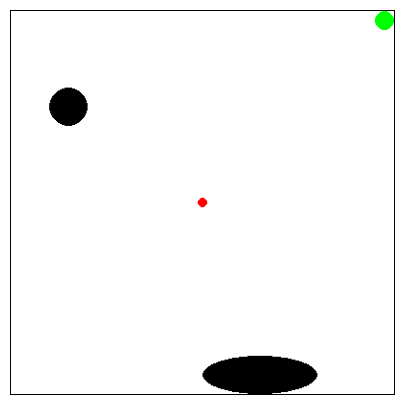

In [19]:
env = gym.make(
        "PuddleWorld-v0",
        start=[0.5,0.5],
        goal=[1.,1.],
        goal_threshold=0.1,
        noise=0.01,
        thrust=0.05,
        puddle_top_left=[[0.1  , 0.8],[0.5, 0.1 ]],
        puddle_width=[[0.1, 0.1 ],[0.3, 0.1]]
    )

obs, info = env.reset()
image = env.render()
fig, ax = plt.subplots(figsize=(5, 5))
online_rendering(image)
